Этот ноутбук необходим для демонстрации нового метода анализа MoE моделей

В нём есть:
- код загрузки модели
- модификации для анализа
- построение эмбеддингов
- кластеризация
- простой анализ кластеров

Также мы загрузили подсчитанные эмбеддинги на huggingface, поскольку их подсчет занимает довольно много времени

# Загрузка модели

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer
from tokenizers.processors import TemplateProcessing
import torch
tokenizer = AutoTokenizer.from_pretrained("ai-sage/GigaChat-20B-A3B-base", trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained("ai-sage/GigaChat-20B-A3B-base", trust_remote_code=True)
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
model.eval()

tokenizer.backend_tokenizer.post_processor = TemplateProcessing(
    single=["<s>", "$A", "</s>"],
    pair=["$A", "$B"],
    special_tokens=[
        ("<s>", 1),    # (token, token_id)
        ("</s>", 2),
        ("<unk>", 0)
    ]
)

# Модифицируем MoE роутеры
Это необходимо для извлечения эмбеддингов. Сделаем небольшой хак и подменим форвард у роутеров. Будем сохранять, каких экспертов выбрал каждый роутер.

In [2]:
import torch.nn.functional as F


class NewForward:
    def __init__(self, old_forward):
        self.old_forward = old_forward

    def new_forward(self, x):
        nf_self = self.old_forward.__self__ if hasattr(
            self.old_forward, '__self__') else self.old_forward.args[0]

        topk_idx, topk_weight, aux_loss = self.old_forward(x)

        nf_self.saved_fires.append(topk_idx) # Здесь мы записываем, каких экспертов выбрал роутер MoE слоя

        return topk_idx, topk_weight, aux_loss


def inject_to_moe(gate):
    gate.saved_fires = []

    old_forward = gate.forward if not hasattr(
        gate, 'nf') else gate.nf.old_forward

    gate.nf = NewForward(old_forward)
    gate.forward = gate.nf.new_forward


for layer in model.base_model.layers:
    if hasattr(layer, "mlp") and hasattr(layer.mlp, "gate"):
        inject_to_moe(layer.mlp.gate)

In [3]:
def get_moe_layers(model):
    for layer_id in range(len(model.base_model.layers)):
        layer = model.base_model.layers[layer_id]
        if hasattr(layer, "mlp") and hasattr(layer.mlp, "gate"):
            yield layer_id, layer

def reset_counters(model):
    for _, layer in get_moe_layers(model):
        gate = layer.mlp.gate
        gate.saved_fires = []

# Pile

Подгрузим pile и возьмем 40 000 сэмлов из него

In [19]:
from datasets import load_dataset

num_samples_to_take = 40000
ds = load_dataset("monology/pile-uncopyrighted", cache_dir="./pile", split="train", streaming=True)
ds = ds.take(num_samples_to_take)

# Построим эмбеддинги
Для каждого из 40 000 сэмлов построим эмбеддинг. Будем для каждого токена записывать, какие эксперты выбирались на каждом слое, построим из этого вектора, а затем усредним

In [5]:
def generate_text(
    prompt,
    model,
    tokenizer,
    truncation=False,
    context_length=None,
):
    t = tokenizer(
        prompt,
        return_tensors="pt",
        truncation=truncation,
        max_length=context_length,
    )
    input_ids = t.input_ids[:, :context_length].to("cuda")
    attention_mask = t.attention_mask[:, :context_length].to("cuda")

    gen_params = {}
    with torch.no_grad():
        gen_params["max_new_tokens"] = 1
        gen_params["input_ids"] = input_ids
        gen_params["attention_mask"] = attention_mask

        out = model.generate(**gen_params, pad_token_id=tokenizer.eos_token_id)

In [6]:
def calculate_freq_embedding(model):
    num_experts = model.config.n_routed_experts

    embedding = []
    for idx, layer in get_moe_layers(model):
        gate = layer.mlp.gate
        fires = gate.saved_fires
        one_hot = F.one_hot(fires[0], num_experts)
        one_hot_sum = torch.sum(one_hot, dim=1).double()
        summed_fires = torch.sum(one_hot_sum, dim=0)
        normalized = summed_fires / torch.sum(summed_fires)
        embedding += normalized.tolist()
    return embedding

In [ ]:
from numpy.random import default_rng
from tqdm import tqdm
import gc
import json

embeddings = []

for sample in tqdm(ds):
    sample_text = sample['text']
    meta = sample['meta']

    reset_counters(model)
    generate_text(
        sample_text,
        model=model,
        tokenizer=tokenizer,
        context_length=512
    )

    embedding = calculate_freq_embedding(model)
    embeddings.append(
        {
            "embedding": embedding,
            "text": sample_text,
            "meta": meta
        }
    )

    torch.cuda.empty_cache()
    gc.collect()


with open("./embeddings_20b.json", "w") as f:
    json.dump(embeddings, f)

# Umap
Визуализируем + кластеризуем наши эмбеддинги

In [6]:
import json
from datasets import load_dataset

# переключение на заранее подсчитанные эмбеддинги
try:
    with open("./embeddings_20b.json", "r") as f:
        embeddings = json.load(f)
except FileNotFoundError:
    dataset = load_dataset("Elluran/concentration_embeddings", 'embeds')
    embeddings = dataset['train']
    

In [3]:
import umap.umap_ as umap
import pandas as pd
import numpy as np

df = pd.DataFrame([np.array(embed['embedding']) for embed in embeddings])
manifold = umap.UMAP(n_neighbors=4, min_dist=0, random_state=42)
manifold.fit(df)
X_reduced = manifold.transform(df)

/home/jovyan/.mlspace/envs/ellur4n-moe/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


/tmp/ipykernel_1950/44093935.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


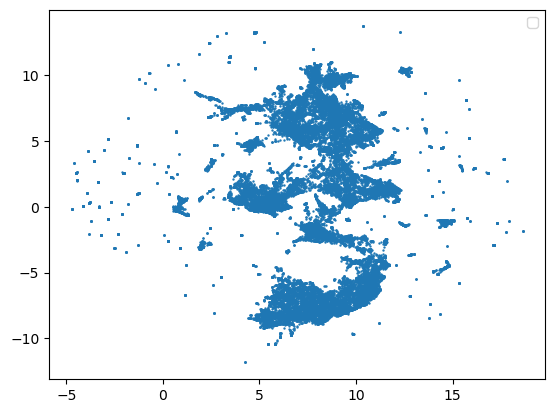

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.scatter(X_reduced[:, 0], X_reduced[:, 1], s=0.5);
plt.legend()

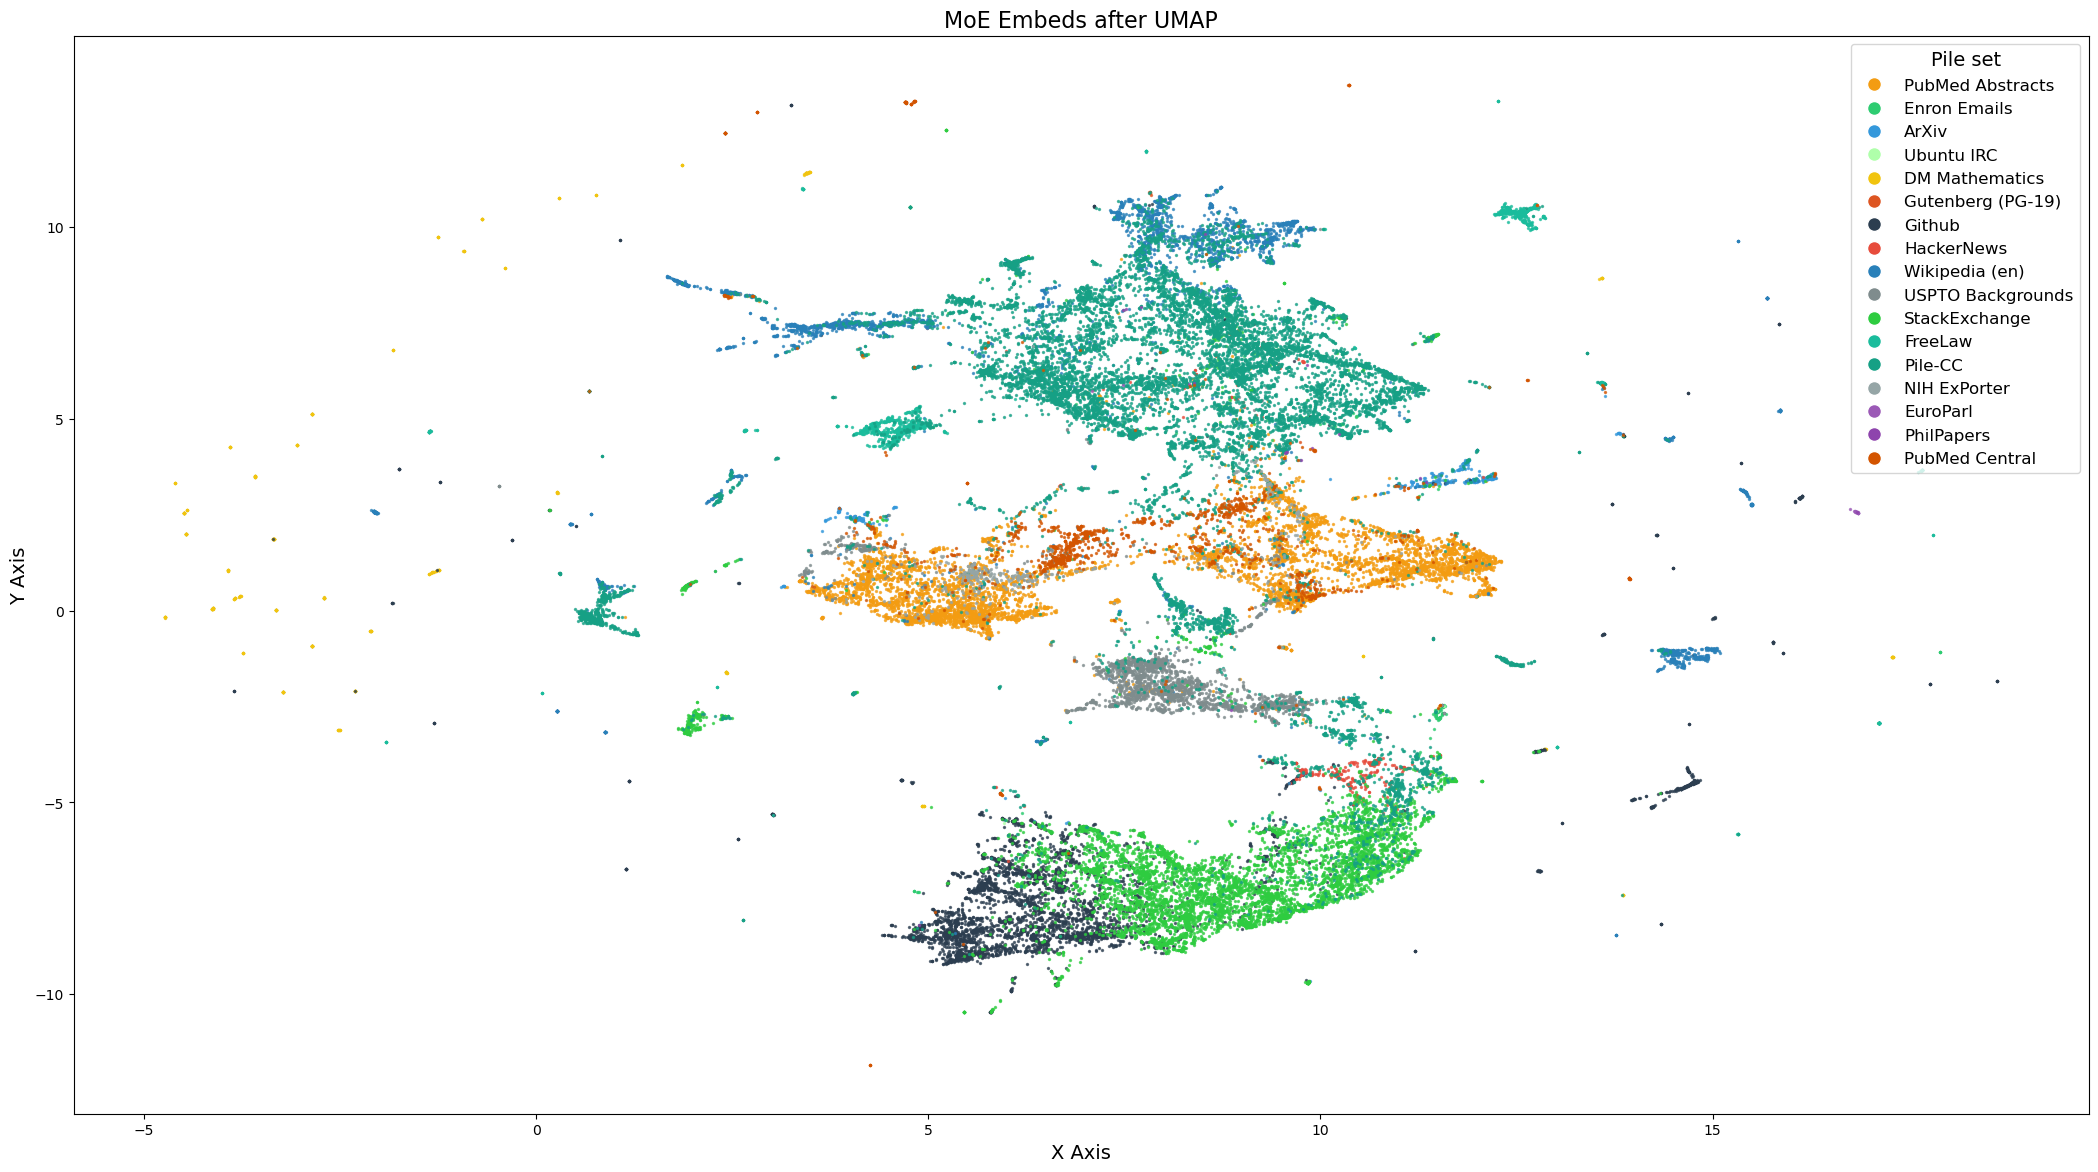

In [10]:
import matplotlib.pyplot as plt
import numpy as np

dataset_color_map = {
    'ArXiv': '#3498db',
    'DM Mathematics': '#f1c40f',
    'Enron Emails': '#2ecc71',
    'EuroParl': '#9b59b6',
    'FreeLaw': '#1abc9c',
    'Github': '#2c3e50',
    'HackerNews': '#e74c3c',
    'NIH ExPorter': '#95a5a6',
    'PhilPapers': '#8e44ad',
    'Pile-CC': '#16a085',
    'PubMed Abstracts': '#f39c12',
    'PubMed Central': '#d35400',
    'StackExchange': '#2ecc40',
    'USPTO Backgrounds': '#7f8c8d',
    'Wikipedia (en)': '#2980b9',
    'Ubuntu IRC': '#AFFFAA',
    'Gutenberg (PG-19)': '#DD5522'
}

pile_sets = list(set(embed["meta"]['pile_set_name'] for embed in embeddings))

fig, ax = plt.subplots(figsize=(26, 14))

for pile_set in pile_sets:
    pile_set_points = [(x, y) for x, y, embed in zip(X_reduced[:, 0], X_reduced[:, 1], embeddings)
                       if embed["meta"]['pile_set_name'] == pile_set]
    
    x_points, y_points = zip(*pile_set_points)
    
    ax.scatter(
        x_points, y_points,
        c=dataset_color_map[pile_set],
        s=2,
        label=pile_set,
        alpha=0.7
    )

handles, labels = ax.get_legend_handles_labels()
legend_handles = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=dataset_color_map[label], markersize=10, label=label)
    for label in labels
]
ax.legend(
    handles=legend_handles,
    title="Pile set",
    fontsize=12,
    title_fontsize=14,
    loc='upper right'
)


ax.set_title('MoE Embeds after UMAP', fontsize=16)
ax.set_xlabel('X Axis', fontsize=14)
ax.set_ylabel('Y Axis', fontsize=14)
ax.set_facecolor('white')
fig.patch.set_facecolor('white')

plt.show()

Также сохраним интерактивную версию этого графика, где можно будет увидеть кусочки сэмплов

In [11]:
import plotly.graph_objects as go
import json
from textwrap import wrap


annotations = []
for embed in embeddings:
    annotation = embed["text"][:512]
    annotation = "<br>".join(wrap(annotation, 60)) + "<br>" + \
        embed["meta"]['pile_set_name']
    annotations.append(annotation)

fig = go.Figure()
pile_sets = list(set(embed["meta"]['pile_set_name'] for embed in embeddings))

for pile_set in pile_sets:
    pile_set_points = [(x, y, prompt) for x, y, prompt, embed in zip(X_reduced[:, 0], X_reduced[:, 1], annotations, embeddings)
                       if embed["meta"]['pile_set_name'] == pile_set]

    x_points, y_points, hover_texts = zip(*pile_set_points)

    fig.add_trace(go.Scatter(
        x=x_points,
        y=y_points,
        mode='markers',
        hoverinfo='text',
        hovertext=hover_texts,
        marker=dict(
            color=dataset_color_map[pile_set],
            size=2
        ),
        name=pile_set,
        legendgroup=pile_set,
        showlegend=False
    ))


for pile_set in pile_sets:
    fig.add_trace(go.Scatter(
        x=[None],
        y=[None],
        mode='markers',
        marker=dict(
            color=dataset_color_map[pile_set],
            size=10,
        ),
        legendgroup=pile_set,
        showlegend=True,
        name=pile_set
    ))

fig.update_layout(
    title='MoE embeds after UMAP',
    xaxis_title='X Axis',
    yaxis_title='Y Axis',
    legend_title="Pile set",
    legend=dict(
        itemsizing='constant',
        font=dict(size=26),
    ),
    plot_bgcolor='white',
    paper_bgcolor='white'
)

# fig.show()
fig.write_html(
    './umap-plot.html')

# Кластеризация

In [12]:
from hdbscan import flat

clustering = flat.HDBSCAN_flat(X_reduced, n_clusters=70, prediction_data=True, min_cluster_size=50, cluster_selection_method='leaf')

len(set(clustering.labels_))

71

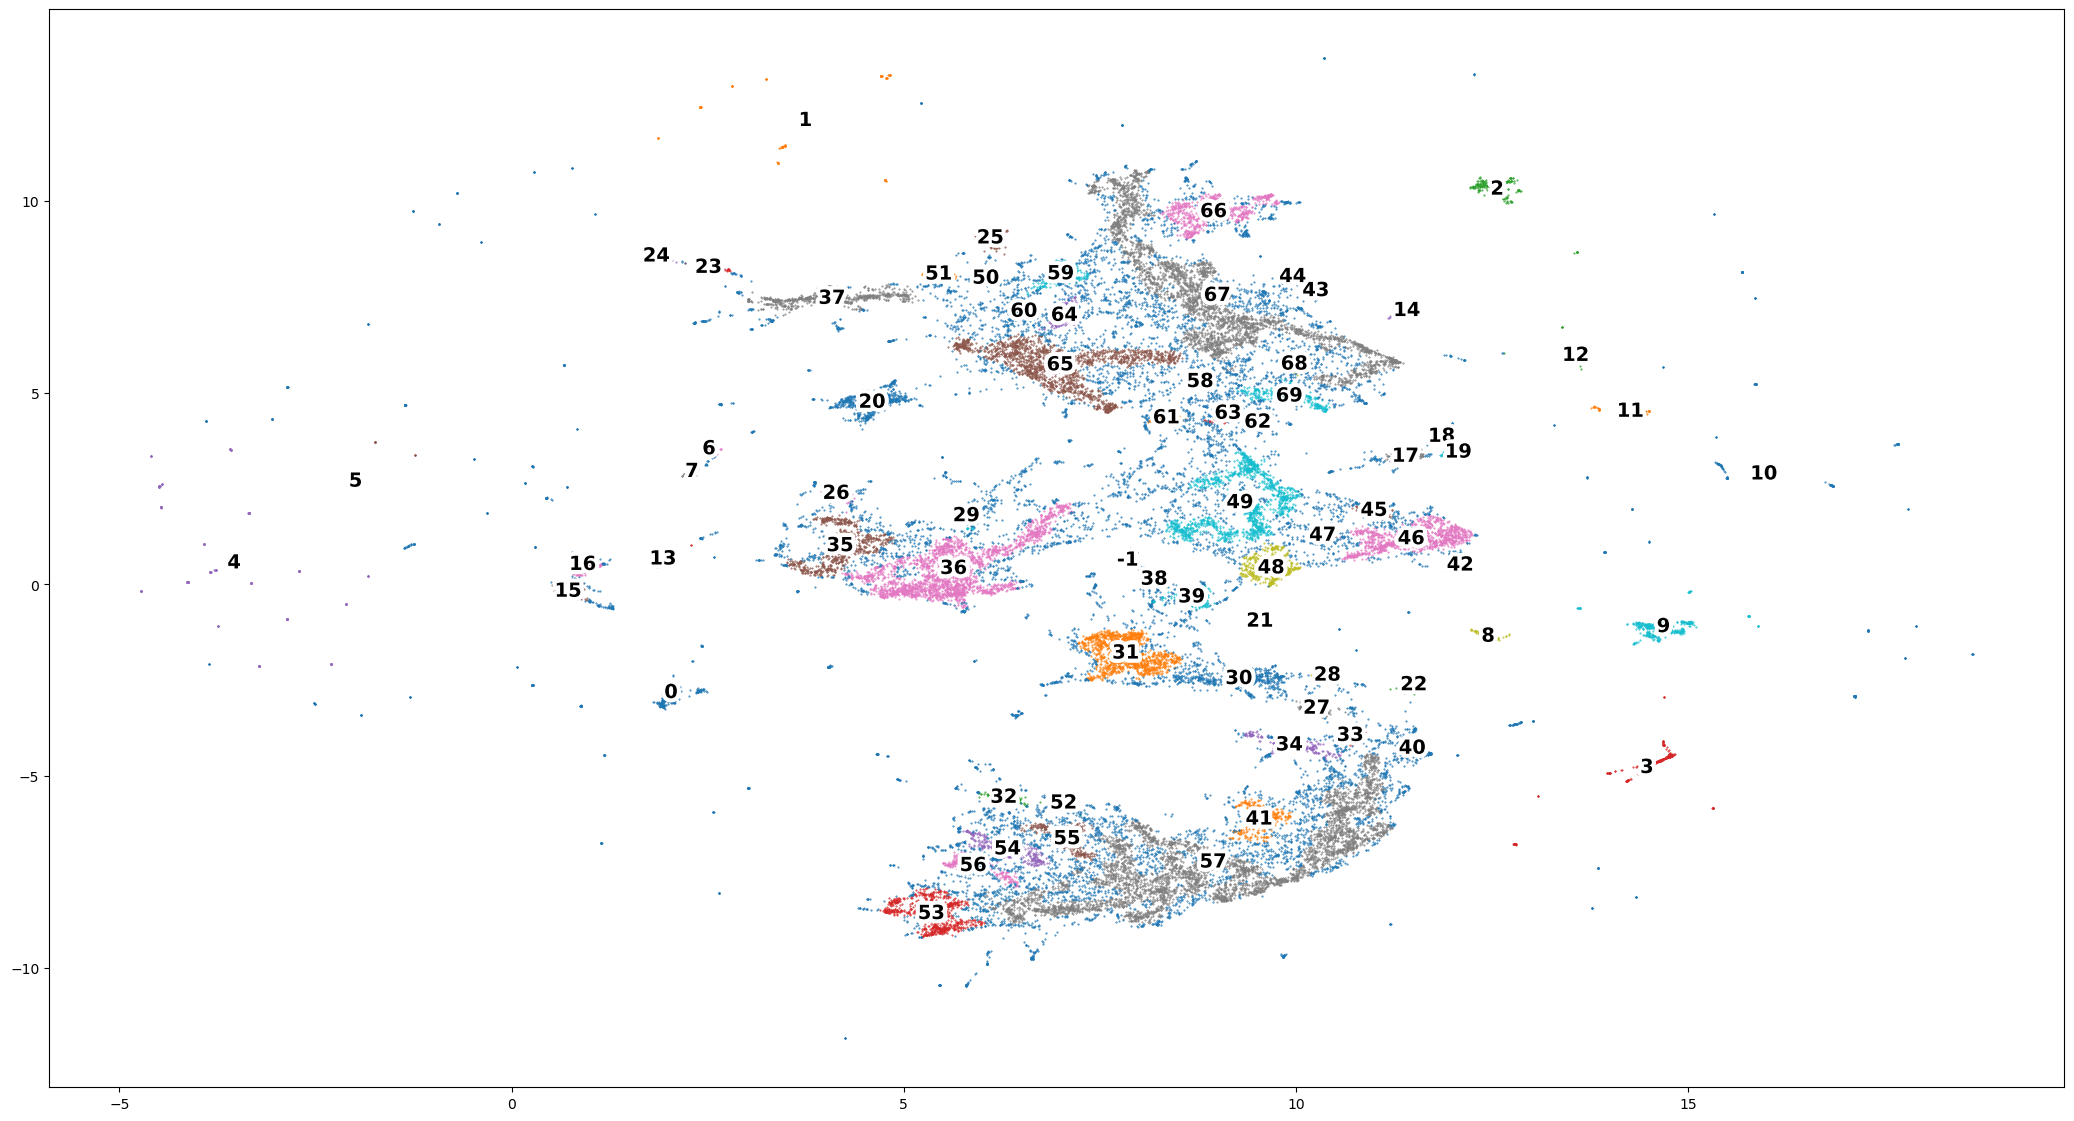

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe

fig, axs = plt.subplots(ncols=1)
fig.set_size_inches(26, 14)

for cluster_idx in set(clustering.labels_):

    plt.scatter(X_reduced[clustering.labels_ == cluster_idx][:, 0],
                X_reduced[clustering.labels_ == cluster_idx][:, 1], label=cluster_idx, s=0.2)

    plt.annotate(cluster_idx,
                 (X_reduced[clustering.labels_ == cluster_idx][:, 0].mean(
                 ), X_reduced[clustering.labels_ == cluster_idx][:, 1].mean()),
                 horizontalalignment='center',
                 verticalalignment='center',
                 size=14, weight='bold',
                 path_effects=[pe.withStroke(linewidth=6, foreground="white")])

Посмотрим на топ 10 ключевых слов в полученных кластерах

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np


def extract_top_keywords(texts, top_n=20):
    vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
    tfidf_matrix = vectorizer.fit_transform(texts)
    feature_names = vectorizer.get_feature_names_out()
    tfidf_scores = np.sum(tfidf_matrix.toarray(), axis=0)
    keywords_scores = list(zip(feature_names, tfidf_scores))
    sorted_keywords = sorted(keywords_scores, key=lambda x: x[1], reverse=True)
    top_keywords = [keyword for keyword, score in sorted_keywords[:top_n]]

    return top_keywords


for cluster_idx in set(clustering.labels_):
    texts = []

    for i in range(len(embeddings)):
        if clustering.labels_[i] == cluster_idx:
            texts.append(embeddings[i]["text"])

    top_keywords = extract_top_keywords(texts, top_n=10)
    print(f"Cluster idx: {cluster_idx:<3} Top Keywords:", top_keywords)

Cluster idx: 0   Top Keywords: ['frac', 'sqrt', 'rural', 'mathbb', 'right', 'pi', 'left', 'infty', 'value', 'theta']
Cluster idx: 1   Top Keywords: ['let', 'sp1', 'sp2', 'solve', 'suppose', '0012', 'states', 'united', 'calculate', 'determine']
Cluster idx: 2   Top Keywords: ['court', 'district', 'united', 'states', 'appellant', 'appeal', 'cir', 'circuit', 'trial', '3d']
Cluster idx: 3   Top Keywords: ['software', 'copyright', 'return', 'string', 'const', 'import', 'use', 'license', 'id', 'void']
Cluster idx: 4   Top Keywords: ['let', 'suppose', 'solve', 'expand', 'sqrt', 'wrt', 'factor', 'digit', 'derivative', 'value']
Cluster idx: 5   Top Keywords: ['born', 'american', 'surname', 'politician', 'refer', 'japanese', 'footballer', 'class', 'david', 'italian']
Cluster idx: 6   Top Keywords: ['league', 'category', 'football', 'race', 'club', 'team', 'stadium', 'hockey', 'season', 'division']
Cluster idx: 7   Top Keywords: ['teams', 'football', 'world', 'group', 'season', 'cup', 'team', 'we

# Сохраним несколько эмбеддингов

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

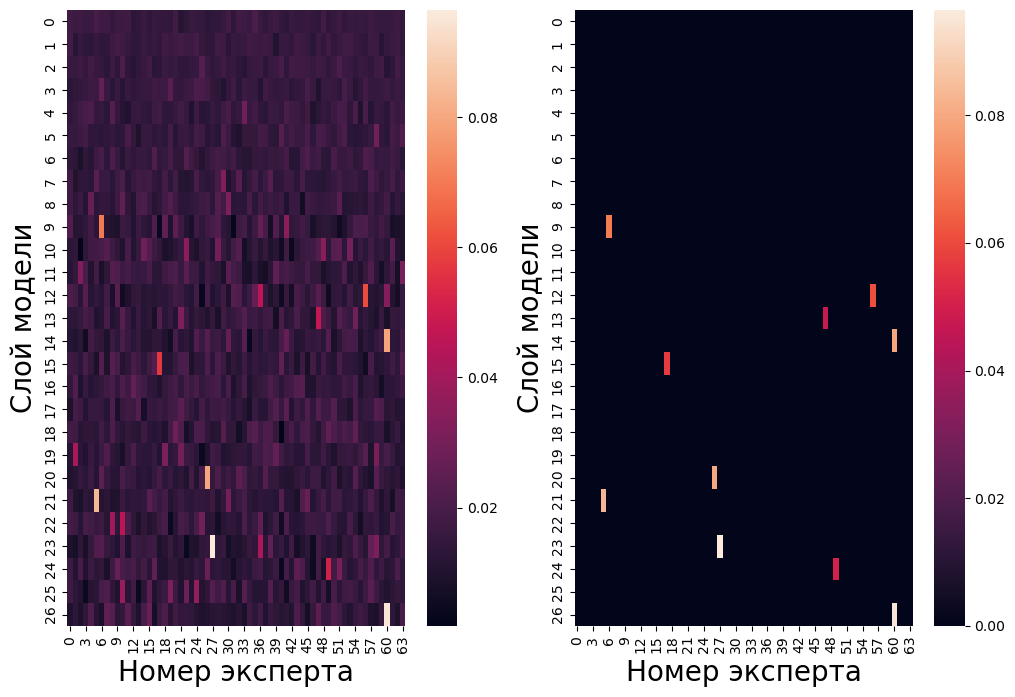

In [16]:
embeds = []

for idx in range(len(embeddings)):
    if clustering.labels_[idx] == 25:
        embeds.append(embeddings[idx]['embedding'])

embed_ = np.mean(embeds, axis=0)
embed_ = np.reshape(embed_, (27, 64))

fig, axs = plt.subplots(ncols=2)
fig.set_size_inches(12, 8)
s = sns.heatmap(embed_, ax=axs[0])
s.set_ylabel('Слой модели', fontsize=20)
s.set_xlabel('Номер эксперта', fontsize=20)
embed_[embed_ < 3 / 64] = 0

s = sns.heatmap(embed_, ax=axs[1])
s.set_ylabel('Слой модели', fontsize=20)
s.set_xlabel('Номер эксперта', fontsize=20)

with open("./food_embed.json", "w") as f:
    json.dump(embed_.tolist(), f)

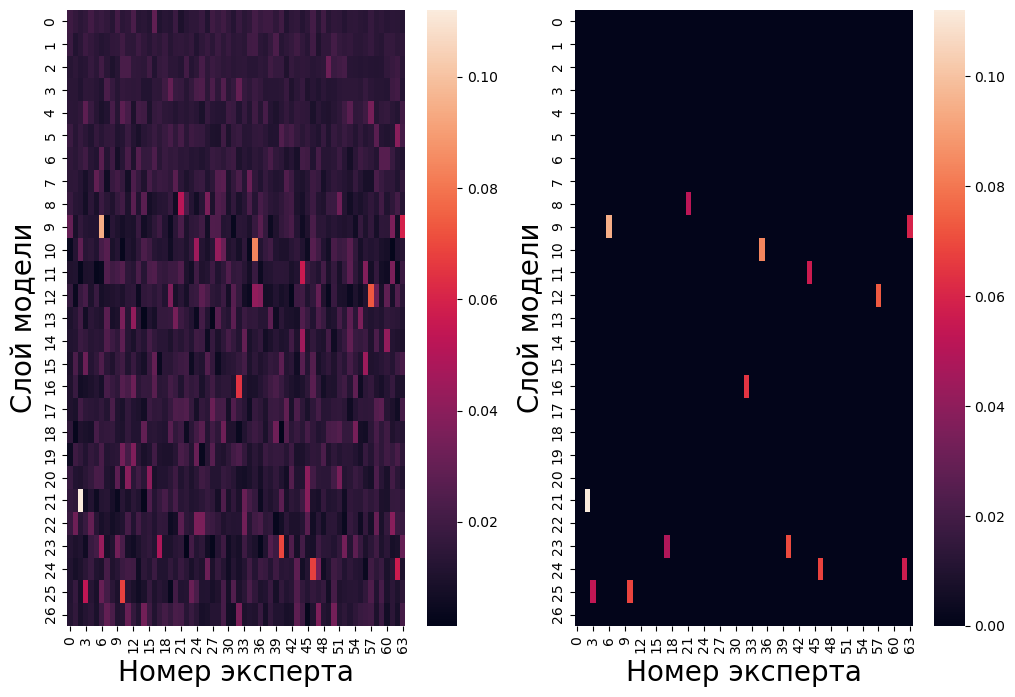

In [17]:
embeds = []

for idx in range(len(embeddings)):
    if clustering.labels_[idx] == 27:
        embeds.append(embeddings[idx]['embedding'])

embed_ = np.mean(embeds, axis=0)
embed_ = np.reshape(embed_, (27, 64))

fig, axs = plt.subplots(ncols=2)
fig.set_size_inches(12, 8)
s = sns.heatmap(embed_, ax=axs[0])
s.set_ylabel('Слой модели', fontsize=20)
s.set_xlabel('Номер эксперта', fontsize=20)
embed_[embed_ < 3 / 64] = 0

s = sns.heatmap(embed_, ax=axs[1])
s.set_ylabel('Слой модели', fontsize=20)
s.set_xlabel('Номер эксперта', fontsize=20)

with open("./software_embed.json", "w") as f:
    json.dump(embed_.tolist(), f)

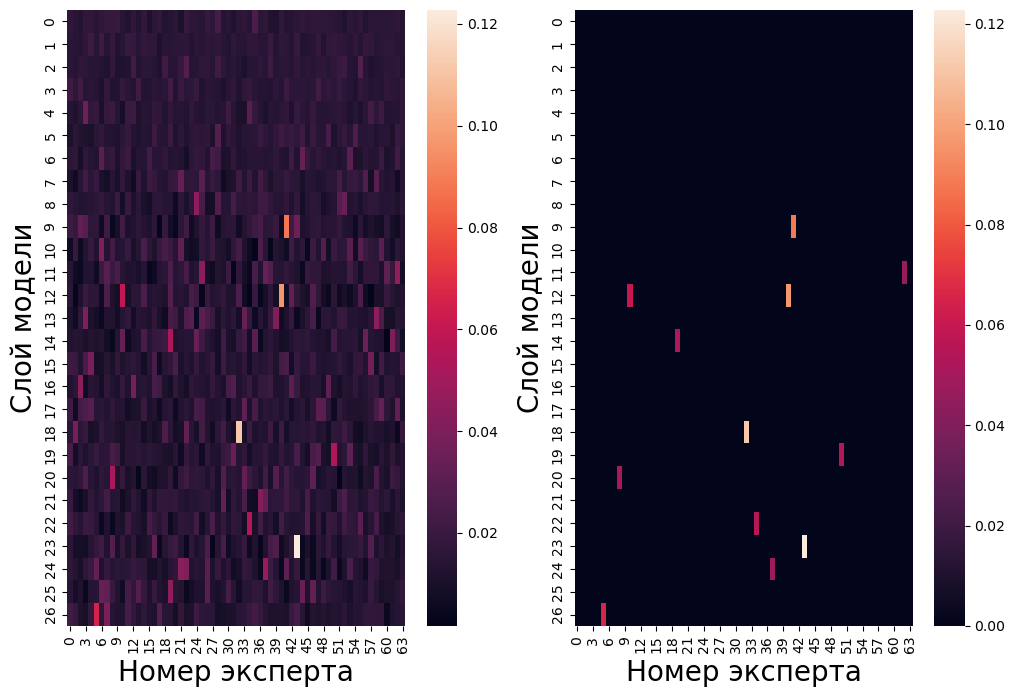

In [18]:
embeds = []

for idx in range(len(embeddings)):
    if clustering.labels_[idx] == 16:
        embeds.append(embeddings[idx]['embedding'])

embed_ = np.mean(embeds, axis=0)
embed_ = np.reshape(embed_, (27, 64))

fig, axs = plt.subplots(ncols=2)
fig.set_size_inches(12, 8)
s = sns.heatmap(embed_, ax=axs[0])
s.set_ylabel('Слой модели', fontsize=20)
s.set_xlabel('Номер эксперта', fontsize=20)
embed_[embed_ < 3 / 64] = 0

s = sns.heatmap(embed_, ax=axs[1])
s.set_ylabel('Слой модели', fontsize=20)
s.set_xlabel('Номер эксперта', fontsize=20)

with open("./sport_embed.json", "w") as f:
    json.dump(embed_.tolist(), f)